# Array 4 Processing: Layered vs. One-Pass Comparison

This notebook evaluates two distinct philosophies for meta-atom defect classification on Array 4 to prove the effectiveness of physical feature isolation.

### Method A: Layered-Consensus (The Proposed Pipeline)
- Uses sequential physical feature isolation (Missing -> Collapsed -> Stitching -> Irregular).
- Includes **Spatial Consensus Thresholding**: A row or column is only flagged as 'Stitching' if $\ge 5$ tiles in that line are detected.

### Method B: Global One-Pass (The Baseline)
- Extracts all available features into a single high-dimensional matrix.
- Computes a **Cumulative Anomaly Score** (sum of absolute normalized feature deviations).
- Partitions the dataset in a single K-Means clustering pass.

In [ ]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Ensure project root is in sys.path
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from defect_analysis.clustering.layered_clustering import (
    load_tiles, run_layered_pipeline, extract_center_intensity, 
    extract_darkness_area, extract_stitching_features, 
    extract_rotation_symmetry, extract_neighbor_deviation
)

plt.rcParams.update({
    'font.size': 11, 'figure.dpi': 120, 'axes.titleweight': 'bold',
    'legend.frameon': True, 'legend.facecolor': 'white'
})

RESULTS_DIR = PROJECT_ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)
ORDER = ['Good', 'Missing', 'Collapsed', 'Stitching', 'Irregular']

## 1. Data Loading

In [ ]:
DATA_DIR = PROJECT_ROOT / 'data' / 'Meta_Atoms'
tiles = load_tiles(DATA_DIR, ['Array_4'])
print(f"Loaded {len(tiles)} meta-atom samples from Array 4.")

Loaded 441 meta-atom samples from Array 4.


## 2. Method A Exploration: Refined Layered-Consensus

In [ ]:
print("Executing Refined Layered-Consensus Pipeline...")
for t in tiles: t.defect_type = 'Unknown' # Reset state

run_layered_pipeline(tiles, verbose=True)
df_a = pd.DataFrame([t.to_dict() for t in tiles])

print("\nMethod A Statistics:")
counts_a = df_a['defect_type'].value_counts().reindex(ORDER).fillna(0).astype(int)
display(counts_a.to_frame(name='Count'))

Executing Refined Layered-Consensus Pipeline...
Layer 1: Missing Detection (Center Intensity)...
  Extracted: 15 | Remaining: 426
Layer 2: Collapsed Detection (Darkness + Area)...


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


  Extracted: 26 | Remaining: 400
Layer 3: Stitching Detection (Sharp Contrast)...


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


  Stitching Candidate Mean Score: 10.64
  Row hit counts: []
  Col hit counts: []
  [Gating] Stitching candidate scores too low; treating as noise/irregular.
  Systemic Stitching: 0 | False Positives -> Irregular: 37 | Remaining: 363
Layer 4: Contextual Features...
  LOF Outliers (Irregular): 10
  Good: 353

Method A Statistics:


,Count
defect_type,
Good,353
Missing,15
Collapsed,26
Stitching,0
Irregular,47


## 3. Method B Exploration: One-Pass Cumulative Scoring

In [ ]:
print("Building One-Pass Cumulative Score Feature Matrix...")

f1 = extract_center_intensity(tiles)
f2 = extract_darkness_area(tiles)
f3 = extract_stitching_features(tiles)
f4 = extract_rotation_symmetry(tiles)
f5 = extract_neighbor_deviation(tiles)

X_raw = np.nan_to_num(np.hstack([f1, f2, f3, f4, f5]))
X_norm = StandardScaler().fit_transform(X_raw)

# Cumulative Anomaly Score
cum_score = np.sum(np.abs(X_norm), axis=1)

# Global K-Means
clust_labels = KMeans(n_clusters=5, random_state=42).fit_predict(X_norm)

df_b = pd.DataFrame({'cluster': clust_labels, 'cum_score': cum_score})
# Map to defect names for comparison
mapping = {c: df_a.loc[clust_labels==c, 'defect_type'].mode()[0] for c in range(5)}
df_b['defect_type'] = df_b['cluster'].map(mapping)

print("\nMethod B Statistics:")
counts_b = df_b['defect_type'].value_counts().reindex(ORDER).fillna(0).astype(int)
display(counts_b.to_frame(name='Count'))

Building One-Pass Cumulative Score Feature Matrix...

Method B Statistics:


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Count
defect_type,
Good,361
Missing,14
Collapsed,25
Stitching,0
Irregular,41


## 4. Spatial Distribution Comparison

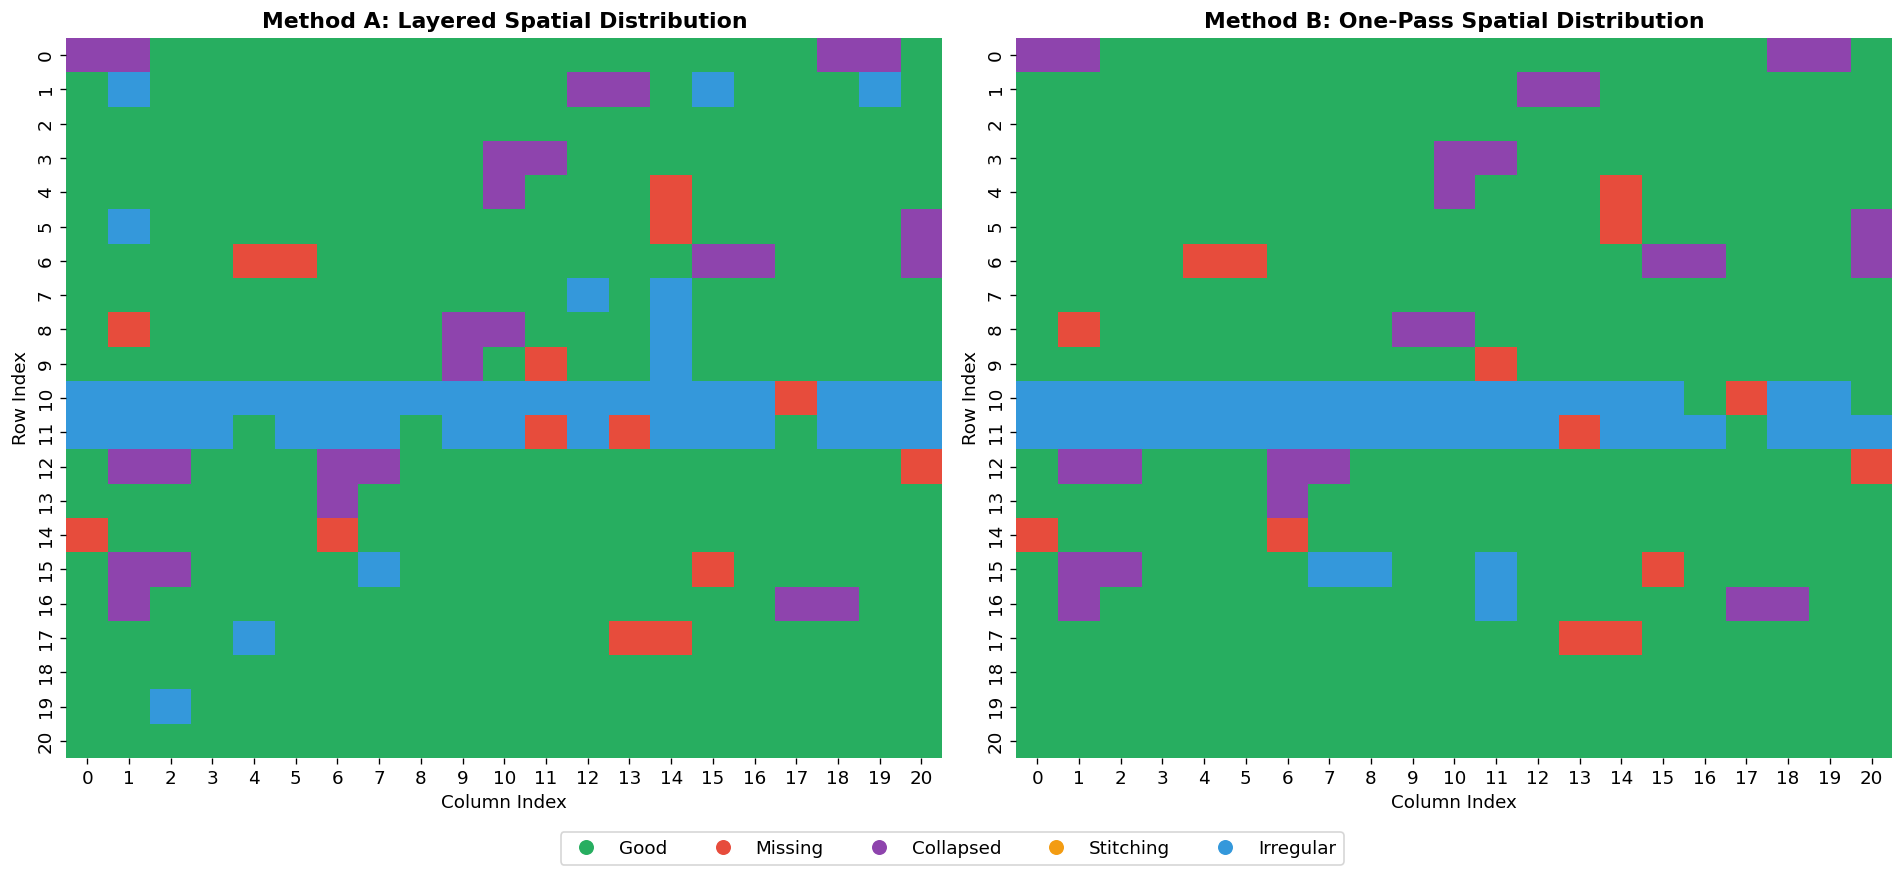

In [ ]:
def plot_defect_heatmaps(df_a, df_b):
    # Extract unique rows and cols to determine grid size
    rows = sorted(df_a['row'].unique())
    cols = sorted(df_a['col'].unique())
    
    # Build numeric maps for defects
    defect_map = {d: i for i, d in enumerate(ORDER)}
    
    grid_a = np.zeros((len(rows), len(cols)))
    grid_b = np.zeros((len(rows), len(cols)))
    
    for _, r in df_a.iterrows():
        r_idx = rows.index(r['row'])
        c_idx = cols.index(r['col'])
        grid_a[r_idx, c_idx] = defect_map[r['defect_type']]
        
    for i, (_, r) in enumerate(df_b.iterrows()):
        # Assumes df_b order matches df_a
        r_orig = df_a.iloc[i]
        r_idx = rows.index(r_orig['row'])
        c_idx = cols.index(r_orig['col'])
        grid_b[r_idx, c_idx] = defect_map[r['defect_type']]
        
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Custom colormap using the palette colors
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['#27ae60', '#e74c3c', '#8e44ad', '#f39c12', '#3498db'])
    
    sns.heatmap(grid_a, ax=axes[0], cmap=cmap, cbar=False)
    axes[0].set_title("Method A: Layered Spatial Distribution")
    axes[0].set_xlabel("Column Index")
    axes[0].set_ylabel("Row Index")
    
    sns.heatmap(grid_b, ax=axes[1], cmap=cmap, cbar=False)
    axes[1].set_title("Method B: One-Pass Spatial Distribution")
    axes[1].set_xlabel("Column Index")
    axes[1].set_ylabel("Row Index")
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=d, 
                              markerfacecolor=c, markersize=10) 
                       for d, c in zip(ORDER, ['#27ae60', '#e74c3c', '#8e44ad', '#f39c12', '#3498db'])]
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'spatial_heatmaps_comparison.png')
    plt.show()

plot_defect_heatmaps(df_a, df_b)

## 5. Visual Specificity Galleries

C:\Users\srfdyz\AppData\Local\Temp\ipykernel_15692\1976054477.py:23: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


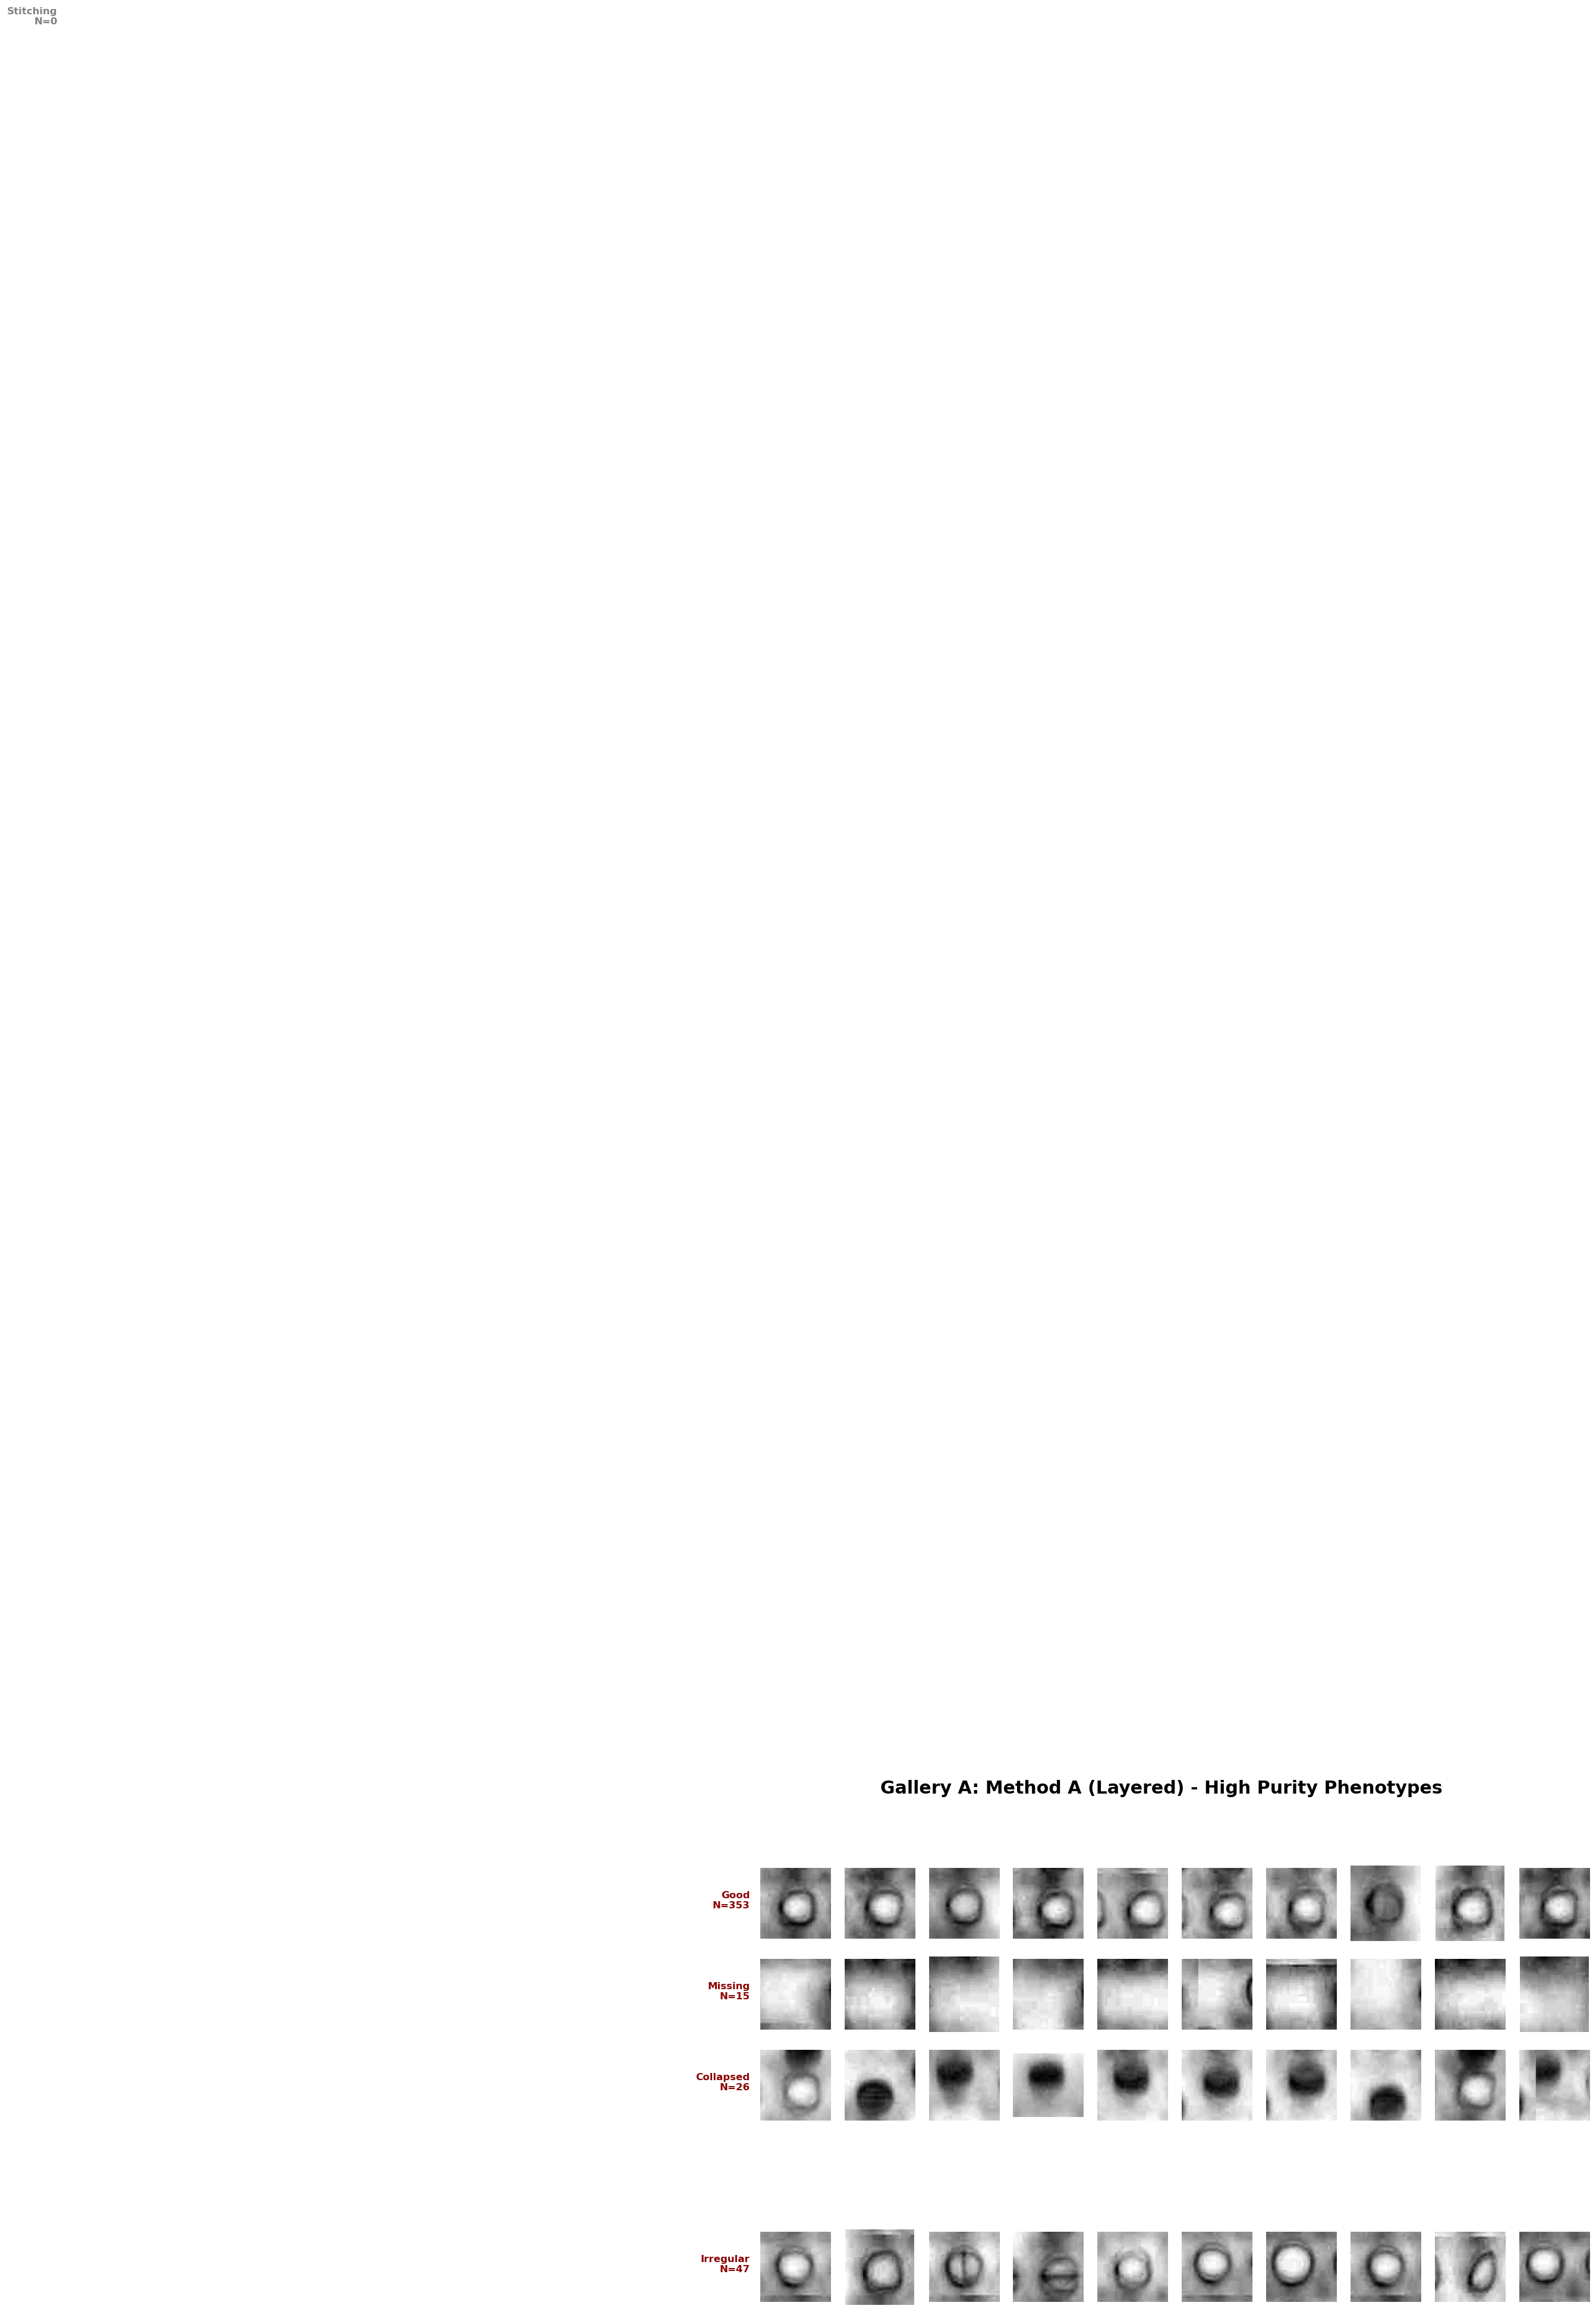

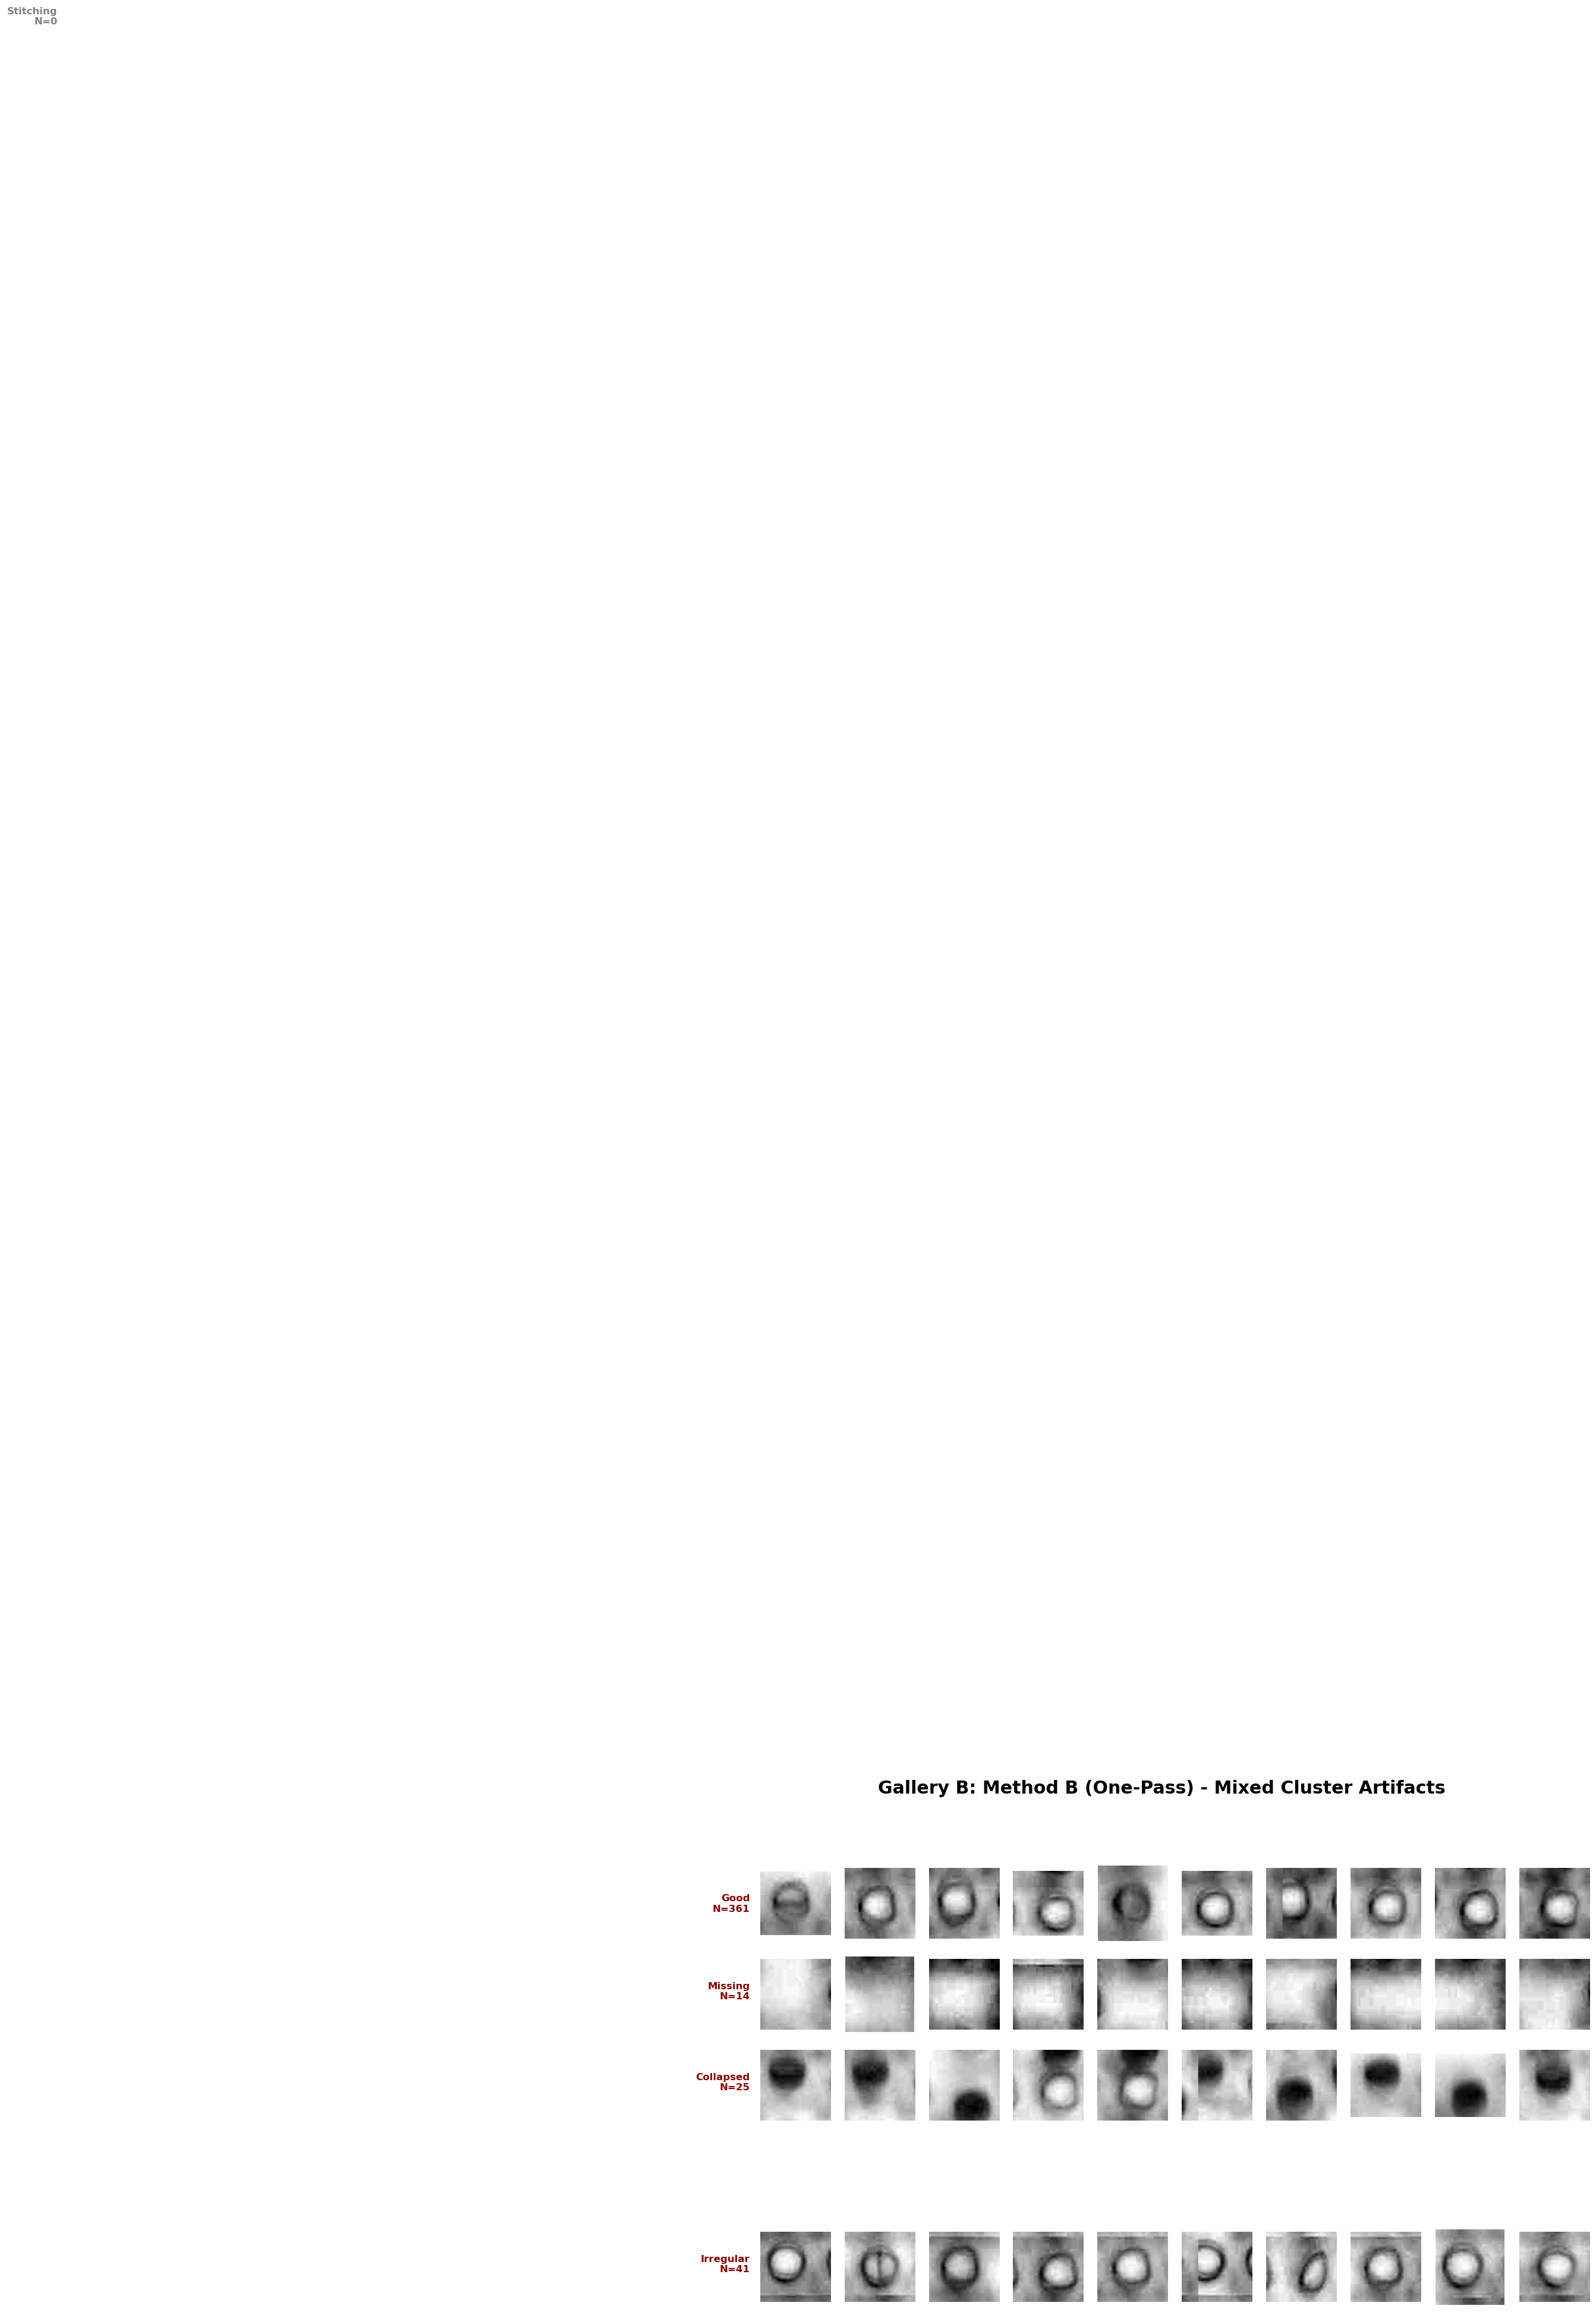

In [ ]:
def show_gallery(tiles, df, title, out_file):
    fig, axes = plt.subplots(len(ORDER), 10, figsize=(15, len(ORDER) * 1.6))
    for i, dtype in enumerate(ORDER):
        indices = df[df['defect_type'] == dtype].index
        n = len(indices)
        if n > 0:
            selection = np.random.choice(indices, min(10, n), replace=False)
            for j in range(10):
                ax = axes[i, j]
                if j < len(selection): 
                    ax.imshow(tiles[selection[j]].image, cmap='gray')
                ax.axis('off')
                if j == 0: 
                    # Add clear row titles to the left of each group
                    ax.text(-10, tiles[0].image.shape[0]//2, f"{dtype}\nN={n}", 
                            ha='right', va='center', fontweight='bold', fontsize=10, color='darkred')
        else:
            for j in range(10): axes[i, j].axis('off')
            axes[i, 0].text(-10, tiles[0].image.shape[0]//2, f"{dtype}\nN=0", 
                             ha='right', va='center', fontweight='bold', fontsize=10, color='gray')
    
    plt.suptitle(title, fontsize=18, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / out_file, bbox_inches='tight')
    plt.show()

show_gallery(tiles, df_a, "Gallery A: Method A (Layered) - High Purity Phenotypes", "gallery_layered_refined.png")
show_gallery(tiles, df_b, "Gallery B: Method B (One-Pass) - Mixed Cluster Artifacts", "gallery_onepass_refined.png")